In [1]:
#Installations, Authentication, and Llama Model Loading
!pip install transformers accelerate bitsandbytes torch datasets scikit-learn matplotlib seaborn umap-learn huggingface_hub

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline as hf_pipeline
# import datasets # Not strictly needed if positive_texts/negative_texts are manually defined
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from huggingface_hub import login, HfFolder

# --- User Configuration ---
MODEL_NAME = "meta-llama/Meta-Llama-3-8B-Instruct"
use_quantization = True # Highly recommended for Colab

# --- Hugging Face Token ---
print("Attempting Hugging Face login...")
try:
    if HfFolder.get_token() is None:
        print("Hugging Face token not found in cache. Please log in when prompted.")
        login() # This will prompt you to enter your token
        print("Login successful (or token was already cached and valid).")
    else:
        print(f"Hugging Face token found in cache: {HfFolder.get_token()[:10]}... (masked)")
except Exception as e:
    print(f"Error during Hugging Face login attempt: {e}")
    print("Please ensure you have a valid Hugging Face token with access to Llama 3.")
    raise

# --- Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cpu':
    print("WARNING: Running on CPU will be very slow. Ensure GPU is enabled in Colab Runtime (Runtime > Change runtime type).")

# --- Load Tokenizer and Model ---
print(f"Loading tokenizer for '{MODEL_NAME}'...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"Tokenizer for '{MODEL_NAME}' loaded.")

print(f"Loading model '{MODEL_NAME}'...")
if use_quantization:
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.bfloat16
    )
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        quantization_config=bnb_config,
        device_map="auto",
        torch_dtype=torch.bfloat16
    )
    print(f"Model '{MODEL_NAME}' loaded with 4-bit quantization.")
else:
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        device_map="auto",
        torch_dtype=torch.bfloat16
    )
    print(f"Model '{MODEL_NAME}' loaded without quantization.")

if tokenizer.pad_token is None:
    if tokenizer.eos_token is not None:
        tokenizer.pad_token = tokenizer.eos_token
        if hasattr(model, 'config') and model.config.pad_token_id is None:
            model.config.pad_token_id = tokenizer.pad_token_id
        print(f"Set pad_token to eos_token: {tokenizer.pad_token} (ID: {tokenizer.pad_token_id})")
    else: # Fallback if eos_token is also None (unlikely for Llama 3)
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        model.resize_token_embeddings(len(tokenizer)) # Adjust model embeddings
        if hasattr(model, 'config'):
            model.config.pad_token_id = tokenizer.pad_token_id
        print(f"Added new pad_token: {tokenizer.pad_token} (ID: {tokenizer.pad_token_id})")

print("Model and tokenizer should be loaded.")

Attempting Hugging Face login...
Hugging Face token found in cache: hf_CNJZIjg... (masked)
Using device: cuda
Loading tokenizer for 'meta-llama/Meta-Llama-3-8B-Instruct'...


tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Tokenizer for 'meta-llama/Meta-Llama-3-8B-Instruct' loaded.
Loading model 'meta-llama/Meta-Llama-3-8B-Instruct'...


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

Model 'meta-llama/Meta-Llama-3-8B-Instruct' loaded with 4-bit quantization.
Set pad_token to eos_token: <|eot_id|> (ID: 128009)
Model and tokenizer should be loaded.


In [3]:
# Cell 2: Define Concept and Prepare Data for Concept Vector (v_C)
CONCEPT_NAME = "sentiment" # The concept we are working with

# Texts for calculating the concept vector (v_C)
positive_texts_for_vc = [
    "This is a wonderful experience and I am very happy.",
    "I love this product, it's absolutely fantastic!",
    "The weather is beautiful today, perfect for a walk.",
    "She gave a truly inspiring and uplifting speech.",
    "What a delightful surprise, it made my day!"
]

negative_texts_for_vc = [
    "This is a terrible situation and I am very upset.",
    "I hate this product, it's absolutely awful!",
    "The weather is miserable today, dreadful for any activity.",
    "His comments were deeply frustrating and disheartening.",
    "What a horrible incident, it ruined everything."
]

print(f"Concept for v_C: {CONCEPT_NAME}")
print(f"Number of positive examples for v_C definition: {len(positive_texts_for_vc)}")
print(f"Number of negative examples for v_C definition: {len(negative_texts_for_vc)}")

Concept for v_C: sentiment
Number of positive examples for v_C definition: 5
Number of negative examples for v_C definition: 5


Targeting module for v_C ACTIVATION EXTRACTION: LlamaDecoderLayer (Layer -1)
Registered v_C extraction hook on layer_minus_1_for_vc.
Using token aggregation strategy: -1 for v_C activation extraction.
Activations for v_C extracted. Pos shape: torch.Size([5, 4096]), Neg shape: torch.Size([5, 4096])

Training Linear Probe for Concept Vector...
Linear probe trained. Training accuracy: 100.00%
Concept vector (v_C) from PROBE calculated. Shape: torch.Size([4096])
v_C Activation extraction hook removed.

Running PCA on activations used for probe...


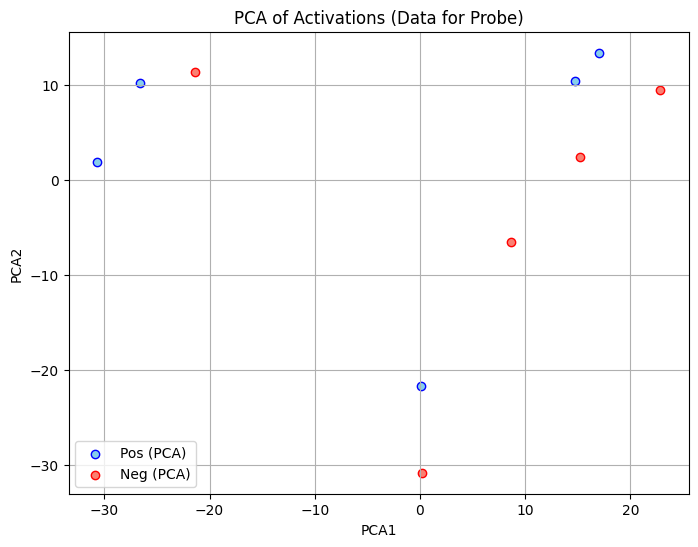

In [4]:
# Cell 3: Activation Extraction, Concept Vector (FROM PROBE), and Optional Visualizations

activations_storage = {}
def get_activation_hook(layer_name_in_storage):
    def hook(model_module, M_input, M_output):
        activations_storage[layer_name_in_storage] = (M_output[0] if isinstance(M_output, tuple) else M_output).detach()
    return hook

target_module_for_vc_extraction = None
hook_handle_vc_extraction = None
# Name for storing activations specifically for v_C calculation
vc_extraction_hook_storage_name = "layer_minus_1_for_vc"

try:
    # For v_C calculation, consistently extract from the last layer (index -1)
    target_module_for_vc_extraction = model.model.layers[-1]
    print(f"Targeting module for v_C ACTIVATION EXTRACTION: {type(target_module_for_vc_extraction).__name__} (Layer -1)")
except Exception as e:
    print(f"Error accessing model.model.layers[-1] for v_C extraction: {e}")

if target_module_for_vc_extraction:
    if 'hook_handle_vc_extraction' in globals() and hook_handle_vc_extraction is not None:
        try: hook_handle_vc_extraction.remove(); print("Removed pre-existing v_C extraction hook.")
        except: pass # Fail silently if already removed or not a valid handle
    hook_handle_vc_extraction = target_module_for_vc_extraction.register_forward_hook(get_activation_hook(vc_extraction_hook_storage_name))
    print(f"Registered v_C extraction hook on {vc_extraction_hook_storage_name}.")
else:
    print("Skipping v_C extraction hook registration as target module not found.")

def get_activations_for_texts_batch(texts_batch, storage_name, agg_token_strategy=-1):
    inputs = tokenizer(texts_batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    if storage_name in activations_storage: del activations_storage[storage_name] # Clear previous
    with torch.no_grad(): _ = model(**inputs)
    batch_activations = activations_storage.get(storage_name)
    if batch_activations is None: raise ValueError(f"Activations not found: '{storage_name}'. Hook issue?")
    batch_activations_cpu = batch_activations.cpu()
    if agg_token_strategy == 'mean': return batch_activations_cpu.mean(dim=1)
    elif agg_token_strategy == -1:
        seq_lens = inputs.attention_mask.sum(dim=1)
        return torch.stack([batch_activations_cpu[i, max(0, seq_lens[i].item()-1), :] for i in range(batch_activations_cpu.shape[0])])
    else: return batch_activations_cpu[:, agg_token_strategy, :]

concept_vector_sentiment = None
positive_activations_for_vc, negative_activations_for_vc = None, None

if hook_handle_vc_extraction and target_module_for_vc_extraction:
    token_aggregation_strategy = -1
    print(f"Using token aggregation strategy: {token_aggregation_strategy} for v_C activation extraction.")
    try:
        positive_activations_for_vc = get_activations_for_texts_batch(positive_texts_for_vc, vc_extraction_hook_storage_name, token_aggregation_strategy)
        negative_activations_for_vc = get_activations_for_texts_batch(negative_texts_for_vc, vc_extraction_hook_storage_name, token_aggregation_strategy)
        print(f"Activations for v_C extracted. Pos shape: {positive_activations_for_vc.shape}, Neg shape: {negative_activations_for_vc.shape}")

        print("\nTraining Linear Probe for Concept Vector...")
        from sklearn.linear_model import LogisticRegression
        from sklearn.preprocessing import StandardScaler
        all_acts_for_probe_torch = torch.cat([positive_activations_for_vc, negative_activations_for_vc], dim=0)
        all_acts_for_probe_numpy = all_acts_for_probe_torch.to(torch.float32).numpy()
        probe_labels = np.array([1]*len(positive_activations_for_vc) + [0]*len(negative_activations_for_vc))
        scaler = StandardScaler(); all_acts_scaled = scaler.fit_transform(all_acts_for_probe_numpy)
        probe_classifier = LogisticRegression(solver='liblinear', C=0.1, class_weight='balanced', random_state=42)
        probe_classifier.fit(all_acts_scaled, probe_labels)
        accuracy = probe_classifier.score(all_acts_scaled, probe_labels)
        print(f"Linear probe trained. Training accuracy: {accuracy*100:.2f}%")
        probe_weights = probe_classifier.coef_[0]
        concept_vector_sentiment = torch.tensor(probe_weights, dtype=torch.bfloat16).to(device)
        # Optional: concept_vector_sentiment = concept_vector_sentiment / torch.norm(concept_vector_sentiment)
        print(f"Concept vector (v_C) from PROBE calculated. Shape: {concept_vector_sentiment.shape}")
    except Exception as e:
        print(f"Error during v_C activation extraction or probe training: {e}")
        concept_vector_sentiment = None
    finally:
        if hook_handle_vc_extraction: hook_handle_vc_extraction.remove(); print("v_C Activation extraction hook removed.")

    # --- Optional Visualizations of Activations used for Probe Training ---
    if positive_activations_for_vc is not None and negative_activations_for_vc is not None:
        all_extracted_activations_float32 = torch.cat([positive_activations_for_vc, negative_activations_for_vc], dim=0).to(torch.float32)
        all_extracted_activations_numpy = all_extracted_activations_float32.numpy()
        n_positive = len(positive_texts_for_vc)
        print("\nRunning PCA on activations used for probe..."); pca = PCA(n_components=2); projected_pca = pca.fit_transform(all_extracted_activations_numpy); plt.figure(figsize=(8,6)); plt.scatter(projected_pca[:n_positive,0], projected_pca[:n_positive,1],label="Pos (PCA)",c="skyblue",edgecolors='b'); plt.scatter(projected_pca[n_positive:,0], projected_pca[n_positive:,1],label="Neg (PCA)",c="salmon",edgecolors='r'); plt.xlabel("PCA1");plt.ylabel("PCA2"); plt.title("PCA of Activations (Data for Probe)"); plt.legend(); plt.grid(True); plt.show()
        # Add t-SNE, UMAP, etc., here if desired, using `all_extracted_activations_numpy`
else:
    print("Initial hook setup for v_C extraction failed. Concept vector cannot be calculated.")

In [5]:
# Cell 3.5: Estimate Activation Ranges for Clipping at Target Steering Layer

min_val_clip = -10.0 # Default fallback
max_val_clip = 10.0  # Default fallback
target_module_for_stats = None # Initialize
hook_handle_stats = None # Initialize

try:
    num_model_layers = len(model.model.layers)
    # Iteration 3 showed Layer -3 (from end) was good. For a 32-layer model, this is index 29.
    layer_for_stats_idx_from_end = -3
    layer_for_stats_actual_idx = num_model_layers + layer_for_stats_idx_from_end

    if not (0 <= layer_for_stats_actual_idx < num_model_layers):
        raise ValueError(f"Calculated layer_for_stats_actual_idx {layer_for_stats_actual_idx} is out of bounds.")

    target_module_for_stats = model.model.layers[layer_for_stats_actual_idx]
    stats_hook_storage_name = f"layer_{layer_for_stats_actual_idx}_stats_activations"
    print(f"Targeting module for activation stats (for clipping ranges): Layer {layer_for_stats_actual_idx} ({type(target_module_for_stats).__name__})")
except Exception as e:
    print(f"Error setting up target_module_for_stats: {e}")

if target_module_for_stats:
    stats_prompts = [
        "The weather today is expected to be clear and sunny.",
        "Standard operational procedures require daily system checks.",
        "A detailed agenda was distributed before the conference began.",
        "The library will be closed for renovations next month.",
        "Historical records indicate a gradual shift in population density."
    ] # Using a few neutral sentences
    # Can also add test_prompts_base if desired: # + test_prompts_base

    activations_for_stats_list = []

    if 'activations_storage' not in globals(): activations_storage = {}
    else:
        if stats_hook_storage_name in activations_storage: del activations_storage[stats_hook_storage_name]

    if target_module_for_stats:
        if 'hook_handle_stats' in globals() and hook_handle_stats is not None:
            try: hook_handle_stats.remove(); print("Removed pre-existing stats hook.")
            except: pass
        hook_handle_stats = target_module_for_stats.register_forward_hook(get_activation_hook(stats_hook_storage_name))
        print(f"Registered temporary hook on layer {layer_for_stats_actual_idx} for stats gathering.")

        print(f"Gathering activations from layer {layer_for_stats_actual_idx} for clipping range estimation...")
        for text in stats_prompts:
            messages = [{"role": "user", "content": text}] # Simple user prompt for stats
            prompt_string = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)
            inputs = tokenizer(prompt_string, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
            if inputs.input_ids.shape[1] == 0: continue
            with torch.no_grad(): _ = model(**inputs)
            current_activations = activations_storage.get(stats_hook_storage_name)
            if current_activations is not None:
                activations_for_stats_list.append(current_activations.cpu().to(torch.float32).view(-1))
            else: print(f"Warning: No activations for '{stats_hook_storage_name}' after prompt: {text[:30]}...")

        if hook_handle_stats: hook_handle_stats.remove(); print("Temporary stats hook removed.")

    if activations_for_stats_list:
        all_stats_activations = torch.cat(activations_for_stats_list)
        if all_stats_activations.numel() > 0 : # Check if tensor is not empty
            min_val_clip = torch.quantile(all_stats_activations, 0.01).item()
            max_val_clip = torch.quantile(all_stats_activations, 0.99).item()
            mean_val_clip = all_stats_activations.mean().item()
            std_val_clip = all_stats_activations.std().item()
            print(f"Activation stats for Layer {layer_for_stats_actual_idx}:")
            print(f"  1st Percentile (min_val_clip): {min_val_clip:.4f}")
            print(f"  99th Percentile (max_val_clip): {max_val_clip:.4f}")
            if min_val_clip >= max_val_clip: # Sanity check
                print(f"Warning: min_val_clip >= max_val_clip. Adjusting based on std dev.");
                min_val_clip = mean_val_clip - 3 * std_val_clip; max_val_clip = mean_val_clip + 3 * std_val_clip
                print(f"  Adjusted range: [{min_val_clip:.4f}, {max_val_clip:.4f}]")
        else: print("No activation values collected. Using default clipping values.")
    else: print("No activations collected for stats. Using default clipping values.")
else:
    print("Target module for stats not set. Using default clipping values.")
print(f"Clipping range to be used for steering: [{min_val_clip:.4f}, {max_val_clip:.4f}]")

Targeting module for activation stats (for clipping ranges): Layer 29 (LlamaDecoderLayer)
Registered temporary hook on layer 29 for stats gathering.
Gathering activations from layer 29 for clipping range estimation...
Temporary stats hook removed.
Activation stats for Layer 29:
  1st Percentile (min_val_clip): -0.8711
  99th Percentile (max_val_clip): 0.8750
Clipping range to be used for steering: [-0.8711, 0.8750]


In [11]:
# You would still need concept_vector_sentiment from Cell 3
# and champion_steering_module_i4_wc (Layer 29) defined as before.
test_prompts_base = ["The report covered several key areas of the project", "During the weekly meeting, the team discussed", "The system update is scheduled to deploy", "Feedback from the initial user testing indicated", "Further analysis of the data revealed that"]
sentiment_classifier_pipe, ppl_model, ppl_tokenizer = None, None, None # Initialize
try:
    sentiment_classifier_pipe = hf_pipeline("sentiment-analysis", device=0 if torch.cuda.is_available() else -1); print("Sentiment classifier loaded.")
except Exception as e: print(f"Error loading sentiment classifier: {e}")

def score_concept_control(generated_texts, target_sentiment_label="POSITIVE", target_score_threshold=0.7):
    if not generated_texts or sentiment_classifier_pipe is None: return 0.0
    valid_texts = [t for t in generated_texts if isinstance(t, str) and t.strip()];
    if not valid_texts: return 0.0
    sentiments = sentiment_classifier_pipe(valid_texts)
    controlled_count = sum(1 for r in sentiments if r['label'].upper() == target_sentiment_label.upper() and r['score'] > target_score_threshold)
    return (controlled_count / len(valid_texts)) * 100 if valid_texts else 0.0

try:
    ppl_model_name = "gpt2"; print(f"Loading PPL model: {ppl_model_name}...")
    ppl_tokenizer = AutoTokenizer.from_pretrained(ppl_model_name)
    ppl_model = AutoModelForCausalLM.from_pretrained(ppl_model_name).to(device)
    if ppl_tokenizer.pad_token is None: ppl_tokenizer.pad_token = ppl_tokenizer.eos_token
    print(f"PPL model '{ppl_model_name}' loaded.")
except Exception as e: print(f"Error loading PPL model: {e}")

def calculate_perplexity(texts_list):
    if not texts_list or ppl_model is None: return float('inf')
    total_nll, total_tokens, valid_texts_count = 0, 0, 0
    for text_item in texts_list:
        if not isinstance(text_item, str) or not text_item.strip(): continue
        max_len = ppl_tokenizer.model_max_length if ppl_tokenizer.model_max_length < 100000 else 1024
        encodings = ppl_tokenizer(text_item,return_tensors="pt",padding=True,truncation=True,max_length=max_len).to(device)
        if encodings.input_ids.numel() == 0: continue
        valid_texts_count +=1
        with torch.no_grad(): outputs = ppl_model(encodings.input_ids, labels=encodings.input_ids)
        total_nll += outputs.loss.item() * encodings.input_ids.size(1); total_tokens += encodings.input_ids.size(1)
    if total_tokens == 0: return float('inf')
    return torch.exp(torch.tensor(total_nll / total_tokens)).item()
print("Evaluation functions and test_prompts_base defined.")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0


Sentiment classifier loaded.
Loading PPL model: gpt2...
PPL model 'gpt2' loaded.
Evaluation functions and test_prompts_base defined.


In [8]:
# Cell 5: MODIFIED for Iteration 4 - Steering Experiment with Activation Clipping

if 'concept_vector_sentiment' not in globals() or concept_vector_sentiment is None:
    print("ERROR: `concept_vector_sentiment` (probe-derived) is not defined from Cell 3.")
elif 'min_val_clip' not in globals() or 'max_val_clip' not in globals():
    print("ERROR: `min_val_clip` or `max_val_clip` not defined from Cell 3.5.")
else:
    print(f"Proceeding with Iteration 4. Probe $v_C$ shape: {concept_vector_sentiment.shape}. Clipping: [{min_val_clip:.4f}, {max_val_clip:.4f}]")

    # --- Iteration 4 Configuration ---
    champion_actual_layer_index_i4 = -1 # Placeholder, will be set
    try:
        num_model_layers_i4 = len(model.model.layers)
        # Use Layer -3 (index 29 for 32-layer model) as champion from Iteration 3
        champion_layer_idx_from_end_i4 = -3
        champion_actual_layer_index_i4 = num_model_layers_i4 + champion_layer_idx_from_end_i4

        if not (0 <= champion_actual_layer_index_i4 < num_model_layers_i4):
            raise ValueError(f"Champion layer index {champion_actual_layer_index_i4} out of bounds.")
        champion_steering_module_i4 = model.model.layers[champion_actual_layer_index_i4]
        champion_steering_module_i4.layer_idx = champion_actual_layer_index_i4 # For logging
        print(f"Champion steering module for Iteration 4: Layer {champion_actual_layer_index_i4} ({type(champion_steering_module_i4).__name__})")
    except Exception as e:
        print(f"Error setting champion_steering_module for Iteration 4: {e}. Cannot proceed."); champion_steering_module_i4 = None

    # Champion alphas from Iteration 3 (for Layer -3)
    alpha_positive_champion_i4 = 0.5
    alpha_negative_champion_i4 = -1.0

    max_new_gen_tokens_i4 = 40
    tokenizer_input_max_len_i4 = 512
    iteration_results_i4 = {}

    # --- Steering Hook Function with CLIPPING (for Iteration 4) ---
    def steering_hook_fn_i4(concept_vector_to_add, alpha_value,
                            p_clip_min, p_clip_max, steer_token_idx=-1): # Removed unused layer_name
        def hook(module, M_input, M_output):
            original_output_tensor = M_output[0] if isinstance(M_output, tuple) else M_output
            modified_output_tensor = original_output_tensor.clone()
            cv_on_correct_device = concept_vector_to_add.to(modified_output_tensor.device, dtype=modified_output_tensor.dtype)
            if steer_token_idx == -1:
                modified_output_tensor[:, -1:, :] = modified_output_tensor[:, -1:, :] + (alpha_value * cv_on_correct_device.unsqueeze(0))
            # Add other steer_token_idx conditions if needed (e.g., None for all tokens)

            modified_output_tensor = torch.clamp(modified_output_tensor, p_clip_min, p_clip_max) # Apply Clipping

            if isinstance(M_output, tuple): return (modified_output_tensor,) + M_output[1:]
            else: return modified_output_tensor
        return hook

    # --- Generate and Evaluate Function (adapted for Iteration 4 logging & clipping) ---
    def generate_and_evaluate_i4(current_run_name, prompts_base_list, steering_module_for_hook,
                                 apply_steering=False, concept_vec=None,
                                 alpha_val=0, target_sentiment_for_ccs=None,
                                 use_clipping=False, p_min_clip_val=-10.0, p_max_clip_val=10.0):
        generated_texts_for_eval = []
        hook_handle_steering_i4 = None
        if apply_steering and steering_module_for_hook and concept_vec is not None:
            steering_hook_instance = steering_hook_fn_i4(concept_vec, alpha_val,
                                                         p_min_clip_val, p_max_clip_val, # Pass clip values
                                                         steer_token_idx=-1)
            hook_handle_steering_i4 = steering_module_for_hook.register_forward_hook(steering_hook_instance)
            print(f"\nGenerating texts for '{current_run_name}' (Layer: {getattr(steering_module_for_hook, 'layer_idx', 'N/A')}, Alpha: {alpha_val:.2f}, Clipping: {'ON' if use_clipping else 'OFF'})...")
        else:
            print(f"\nGenerating texts for '{current_run_name}' (No steering / Baseline)...")

        for p_base in prompts_base_list:
            messages = [{"role": "system", "content": "You are a helpful assistant."}, {"role": "user", "content": f"{p_base}, and in summary, the general feeling was"}]
            prompt_string = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
            inputs = tokenizer(prompt_string, return_tensors="pt", max_length=tokenizer_input_max_len_i4, truncation=True).to(device)
            if inputs.input_ids.shape[1] == 0: generated_texts_for_eval.append(""); continue
            try:
                with torch.no_grad():
                    outputs = model.generate(inputs.input_ids, attention_mask=inputs.attention_mask, max_new_tokens=max_new_gen_tokens_i4,
                                             temperature=0.7, do_sample=True, pad_token_id=tokenizer.pad_token_id, eos_token_id=tokenizer.eos_token_id)
                full_decoded_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
                input_len = inputs.input_ids.shape[1]; completion_only = tokenizer.decode(outputs[0, input_len:], skip_special_tokens=True)
                print(f"  Prompt: '{p_base[:50]}...' -> Completion: '{completion_only[:100]}...'")
                generated_texts_for_eval.append(full_decoded_text)
            except Exception as e: print(f"  Error: {e}"); generated_texts_for_eval.append("")
        if hook_handle_steering_i4: hook_handle_steering_i4.remove()

        current_ppl = calculate_perplexity(generated_texts_for_eval)
        current_ccs = 0.0
        if target_sentiment_for_ccs and generated_texts_for_eval:
            current_ccs = score_concept_control(generated_texts_for_eval, target_sentiment_for_ccs)

        iteration_results_i4[current_run_name] = {"ppl": current_ppl, "ccs": current_ccs if target_sentiment_for_ccs else "N/A",
                                                  "outputs": generated_texts_for_eval, "alpha": alpha_val,
                                                  "steering_layer_idx": getattr(steering_module_for_hook, 'layer_idx', 'N/A' if apply_steering else 'Baseline'),
                                                  "clipping": "ON" if (apply_steering and use_clipping) else "OFF"} # Correctly log clipping
        print(f"Results for '{current_run_name}': PPL: {current_ppl:.2f}", end="")
        if target_sentiment_for_ccs: print(f", CCS ({target_sentiment_for_ccs}): {current_ccs:.2f}%")
        else: print("")
        return generated_texts_for_eval

    # --- Main Execution for Iteration 4 ---
    if champion_steering_module_i4 and ('concept_vector_sentiment' in globals() and concept_vector_sentiment is not None):
        print("\n--- Iteration 4: Evaluating Steering with Activation Clipping ---")
        print(f"Using Champion Steering Layer: {champion_actual_layer_index_i4}")
        print(f"Clipping Min: {min_val_clip:.4f}, Clipping Max: {max_val_clip:.4f}")

        # 1. Positive Steering WITH Clipping
        generate_and_evaluate_i4(
            current_run_name=f"L{champion_actual_layer_index_i4}_clip_ON_pos_alpha_{alpha_positive_champion_i4:.1f}",
            prompts_base_list=test_prompts_base,
            steering_module_for_hook=champion_steering_module_i4,
            apply_steering=True,
            concept_vec=concept_vector_sentiment,
            alpha_val=alpha_positive_champion_i4,
            target_sentiment_for_ccs="POSITIVE",
            use_clipping=True, # Enable clipping
            p_min_clip_val=min_val_clip,
            p_max_clip_val=max_val_clip
        )

        # 2. Negative Steering WITH Clipping
        generate_and_evaluate_i4(
            current_run_name=f"L{champion_actual_layer_index_i4}_clip_ON_neg_alpha_{alpha_negative_champion_i4:.1f}",
            prompts_base_list=test_prompts_base,
            steering_module_for_hook=champion_steering_module_i4,
            apply_steering=True,
            concept_vec=concept_vector_sentiment,
            alpha_val=alpha_negative_champion_i4,
            target_sentiment_for_ccs="NEGATIVE",
            use_clipping=True, # Enable clipping
            p_min_clip_val=min_val_clip,
            p_max_clip_val=max_val_clip
        )

        # For direct comparison, also run WITHOUT clipping using the champion settings
        print("\n--- Comparison: Run with the same settings without clipping ---")
        generate_and_evaluate_i4(
            current_run_name=f"L{champion_actual_layer_index_i4}_clip_OFF_pos_alpha_{alpha_positive_champion_i4:.1f}",
            prompts_base_list=test_prompts_base,
            steering_module_for_hook=champion_steering_module_i4,
            apply_steering=True, # Steering is on
            concept_vec=concept_vector_sentiment,
            alpha_val=alpha_positive_champion_i4,
            target_sentiment_for_ccs="POSITIVE",
            use_clipping=False # Clipping is OFF
        )
        generate_and_evaluate_i4(
            current_run_name=f"L{champion_actual_layer_index_i4}_clip_OFF_neg_alpha_{alpha_negative_champion_i4:.1f}",
            prompts_base_list=test_prompts_base,
            steering_module_for_hook=champion_steering_module_i4,
            apply_steering=True, # Steering is on
            concept_vec=concept_vector_sentiment,
            alpha_val=alpha_negative_champion_i4,
            target_sentiment_for_ccs="NEGATIVE",
            use_clipping=False # Clipping is OFF
        )

        print("\n--- Iteration 4 Evaluation Complete ---")
        print("\nSummary of Iteration 4 Results (Activation Clipping vs. No Clipping):")
        for run_name, metrics in iteration_results_i4.items():
            layer_info = metrics.get('steering_layer_idx', 'N/A')
            clip_info = metrics.get('clipping', 'N/A')
            print(f"  Run: {run_name}, SteeringLayer: {layer_info}, Alpha: {metrics.get('alpha', 'N/A'):.1f}, Clip: {clip_info}, PPL: {metrics.get('ppl', 'N/A'):.2f}, CCS: {metrics.get('ccs', 'N/A')}")

    else:
        print("Skipping Iteration 4 due to missing prerequisites (champion_steering_module, concept_vector_sentiment, or clip values).")

Proceeding with Iteration 4. Probe $v_C$ shape: torch.Size([4096]). Clipping: [-0.8711, 0.8750]
Champion steering module for Iteration 4: Layer 29 (LlamaDecoderLayer)

--- Iteration 4: Evaluating Steering with Activation Clipping ---
Using Champion Steering Layer: 29
Clipping Min: -0.8711, Clipping Max: 0.8750

Generating texts for 'L29_clip_ON_pos_alpha_0.5' (Layer: 29, Alpha: 0.50, Clipping: ON)...
  Prompt: 'The report covered several key areas of the projec...' -> Completion: 'Please go ahead and complete the sentence A.swing://assistantassistant}

 manufactures://assistant

...'
  Prompt: 'During the weekly meeting, the team discussed...' -> Completion: '.swing://go-ahead-and-voice-your-thoughts-would-you-please-summaries-the-main-points-discussed-durin...'
  Prompt: 'The system update is scheduled to deploy...' -> Completion: 'Hi there! As I understand://update is set to roll out://update. Can you please elaborate on://update...'
  Prompt: 'Feedback from the initial user testing 

In [12]:
# Cell 5: Iteration 4 - Steering Experiment with WIDER Activation Clipping
# Cell to define WIDER clipping values for Iteration 4 Test

# Let's try a fixed generous range first
final_min_clip = -25.0
final_max_clip = 25.0
print(f"DEFINING WIDER fixed clipping range for Iteration 4 test: [{final_min_clip:.4f}, {final_max_clip:.4f}]")

if 'concept_vector_sentiment' not in globals() or concept_vector_sentiment is None:
    print("ERROR: `concept_vector_sentiment` (probe-derived) is not defined from Cell 3. Cannot run Iteration 4.")
elif 'final_min_clip' not in globals() or 'final_max_clip' not in globals(): # Check for the new wider clip vars
    print("ERROR: `final_min_clip` or `final_max_clip` not defined. Please run the cell that calculates these (e.g., end of Cell 3.5).")
else:
    print(f"Proceeding with Iteration 4. Probe $v_C$ shape: {concept_vector_sentiment.shape}.")
    print(f"Using WIDER Clipping range: [{final_min_clip:.4f}, {final_max_clip:.4f}]")

    # --- Iteration 4 Configuration with Wider Clip ---
    champion_actual_layer_index_i4_wc = -1 # Placeholder, will be set
    try:
        num_model_layers_i4_wc = len(model.model.layers)
        champion_layer_idx_from_end_i4_wc = -3
        champion_actual_layer_index_i4_wc = num_model_layers_i4_wc + champion_layer_idx_from_end_i4_wc

        if not (0 <= champion_actual_layer_index_i4_wc < num_model_layers_i4_wc):
            raise ValueError(f"Champion layer index {champion_actual_layer_index_i4_wc} out of bounds.")
        champion_steering_module_i4_wc = model.model.layers[champion_actual_layer_index_i4_wc]
        champion_steering_module_i4_wc.layer_idx = champion_actual_layer_index_i4_wc
        print(f"Champion steering module for Iteration 4 (Wider Clip): Layer {champion_actual_layer_index_i4_wc} ({type(champion_steering_module_i4_wc).__name__})")
    except Exception as e:
        print(f"Error setting champion_steering_module for Iteration 4 (Wider Clip): {e}. Cannot proceed."); champion_steering_module_i4_wc = None

    # Champion alphas from Iteration 3 (for Layer -3 / index 29)
    alpha_positive_champion_i4_wc = 0.5
    alpha_negative_champion_i4_wc = -1.0

    max_new_gen_tokens_i4_wc = 40
    tokenizer_input_max_len_i4_wc = 512
    # Use a new results dictionary for this specific run with wider clipping
    iteration_results_i4_wider_clip = {}

    # --- Steering Hook Function with CLIPPING (for Iteration 4 - Wider Clip) ---
    # This function is the same as steering_hook_fn_i4, just renamed for clarity if you want to keep both
    def steering_hook_fn_i4_wider_clip(concept_vector_to_add, alpha_value,
                                       p_clip_min, p_clip_max, steer_token_idx=-1):
        def hook(module, M_input, M_output):
            original_output_tensor = M_output[0] if isinstance(M_output, tuple) else M_output
            modified_output_tensor = original_output_tensor.clone()
            cv_on_correct_device = concept_vector_to_add.to(modified_output_tensor.device, dtype=modified_output_tensor.dtype)
            if steer_token_idx == -1:
                modified_output_tensor[:, -1:, :] = modified_output_tensor[:, -1:, :] + (alpha_value * cv_on_correct_device.unsqueeze(0))

            modified_output_tensor = torch.clamp(modified_output_tensor, p_clip_min, p_clip_max) # Apply Clipping

            if isinstance(M_output, tuple): return (modified_output_tensor,) + M_output[1:]
            else: return modified_output_tensor
        return hook

    # --- Generate and Evaluate Function (adapted for Iteration 4 - Wider Clip) ---
    def generate_and_evaluate_i4_wider_clip(current_run_name, prompts_base_list, steering_module_for_hook,
                                            apply_steering=False, concept_vec=None,
                                            alpha_val=0, target_sentiment_for_ccs=None,
                                            use_clipping=False, p_min_clip_val=-10.0, p_max_clip_val=10.0): # Default clip values if not passed
        generated_texts_for_eval = []
        hook_handle_steering_i4_wc = None

        # Descriptive print for steering status
        steering_status_msg = "No steering / Baseline"
        if apply_steering and steering_module_for_hook and concept_vec is not None:
            clip_status = "ON" if use_clipping else "OFF"
            steering_status_msg = f"Steering Layer: {getattr(steering_module_for_hook, 'layer_idx', 'N/A')}, Alpha: {alpha_val:.2f}, Clipping: {clip_status}"

            # Only register hook if steering is applied
            steering_hook_instance = steering_hook_fn_i4_wider_clip( # Use the hook that has clipping logic
                concept_vec, alpha_val,
                p_min_clip_val, p_max_clip_val, # Pass clip values from function args
                steer_token_idx=-1
            )
            hook_handle_steering_i4_wc = steering_module_for_hook.register_forward_hook(steering_hook_instance)

        print(f"\nGenerating texts for '{current_run_name}' ({steering_status_msg})...")

        for p_base in prompts_base_list:
            messages = [{"role": "system", "content": "You are a helpful assistant."}, {"role": "user", "content": f"{p_base}, and in summary, the general feeling was"}]
            prompt_string = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
            inputs = tokenizer(prompt_string, return_tensors="pt", max_length=tokenizer_input_max_len_i4_wc, truncation=True).to(device)
            if inputs.input_ids.shape[1] == 0: generated_texts_for_eval.append(""); continue
            try:
                with torch.no_grad():
                    outputs = model.generate(inputs.input_ids, attention_mask=inputs.attention_mask, max_new_tokens=max_new_gen_tokens_i4_wc,
                                             temperature=0.7, do_sample=True, pad_token_id=tokenizer.pad_token_id, eos_token_id=tokenizer.eos_token_id)
                full_decoded_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
                input_len = inputs.input_ids.shape[1]; completion_only = tokenizer.decode(outputs[0, input_len:], skip_special_tokens=True)
                print(f"  Prompt: '{p_base[:50]}...' -> Completion: '{completion_only[:100]}...'")
                generated_texts_for_eval.append(full_decoded_text)
            except Exception as e: print(f"  Error: {e}"); generated_texts_for_eval.append("")
        if hook_handle_steering_i4_wc: hook_handle_steering_i4_wc.remove()

        current_ppl = calculate_perplexity(generated_texts_for_eval)
        current_ccs = 0.0
        if target_sentiment_for_ccs and generated_texts_for_eval:
            current_ccs = score_concept_control(generated_texts_for_eval, target_sentiment_for_ccs)

        iteration_results_i4_wider_clip[current_run_name] = {
            "ppl": current_ppl,
            "ccs": current_ccs if target_sentiment_for_ccs else "N/A",
            "outputs": generated_texts_for_eval, "alpha": alpha_val,
            "steering_layer_idx": getattr(steering_module_for_hook, 'layer_idx', 'N/A' if apply_steering else 'Baseline'),
            "clipping": "ON" if (apply_steering and use_clipping) else "OFF"
        }
        print(f"Results for '{current_run_name}': PPL: {current_ppl:.2f}", end="")
        if target_sentiment_for_ccs: print(f", CCS ({target_sentiment_for_ccs}): {current_ccs:.2f}%")
        else: print("")
        return generated_texts_for_eval

    # --- Main Execution for Iteration 4 (Wider Clip) ---
    if champion_steering_module_i4_wc and ('concept_vector_sentiment' in globals() and concept_vector_sentiment is not None):
        print("\n--- Iteration 4: Evaluating Steering with WIDER Activation Clipping ---")
        print(f"Using Champion Steering Layer: {champion_actual_layer_index_i4_wc}")
        print(f"Using WIDER Clipping Range: [{final_min_clip:.4f}, {final_max_clip:.4f}]") # Uses the values from the small cell above

        # 1. Positive Steering WITH WIDER Clipping
        generate_and_evaluate_i4_wider_clip(
            current_run_name=f"L{champion_actual_layer_index_i4_wc}_WIDERclip_ON_pos_alpha_{alpha_positive_champion_i4_wc:.1f}",
            prompts_base_list=test_prompts_base,
            steering_module_for_hook=champion_steering_module_i4_wc,
            apply_steering=True,
            concept_vec=concept_vector_sentiment,
            alpha_val=alpha_positive_champion_i4_wc,
            target_sentiment_for_ccs="POSITIVE",
            use_clipping=True,
            p_min_clip_val=final_min_clip, # Pass the WIDER clip values
            p_max_clip_val=final_max_clip
        )

        # 2. Negative Steering WITH WIDER Clipping
        generate_and_evaluate_i4_wider_clip(
            current_run_name=f"L{champion_actual_layer_index_i4_wc}_WIDERclip_ON_neg_alpha_{alpha_negative_champion_i4_wc:.1f}",
            prompts_base_list=test_prompts_base,
            steering_module_for_hook=champion_steering_module_i4_wc,
            apply_steering=True,
            concept_vec=concept_vector_sentiment,
            alpha_val=alpha_negative_champion_i4_wc,
            target_sentiment_for_ccs="NEGATIVE",
            use_clipping=True,
            p_min_clip_val=final_min_clip, # Pass the WIDER clip values
            p_max_clip_val=final_max_clip
        )

        # Re-run "Clip: OFF" controls if you want a direct comparison within this exact execution pass.
        # These should ideally match your best Iteration 3 results for Layer 29.
        print("\n--- Comparison: Same settings, Clipping OFF (Should be similar to best Iteration 3 results for Layer 29) ---")
        generate_and_evaluate_i4_wider_clip(
            current_run_name=f"L{champion_actual_layer_index_i4_wc}_WIDERclip_OFF_pos_alpha_{alpha_positive_champion_i4_wc:.1f}",
            prompts_base_list=test_prompts_base,
            steering_module_for_hook=champion_steering_module_i4_wc,
            apply_steering=True,
            concept_vec=concept_vector_sentiment,
            alpha_val=alpha_positive_champion_i4_wc,
            target_sentiment_for_ccs="POSITIVE",
            use_clipping=False # Clipping is OFF
        )
        generate_and_evaluate_i4_wider_clip(
            current_run_name=f"L{champion_actual_layer_index_i4_wc}_WIDERclip_OFF_neg_alpha_{alpha_negative_champion_i4_wc:.1f}",
            prompts_base_list=test_prompts_base,
            steering_module_for_hook=champion_steering_module_i4_wc,
            apply_steering=True,
            concept_vec=concept_vector_sentiment,
            alpha_val=alpha_negative_champion_i4_wc,
            target_sentiment_for_ccs="NEGATIVE",
            use_clipping=False # Clipping is OFF
        )

        print("\n--- Iteration 4 (Wider Clip) Evaluation Complete ---")
        print("\nSummary of Iteration 4 Results (WIDER Activation Clipping vs. No Clipping):")
        for run_name, metrics in iteration_results_i4_wider_clip.items(): # Use the new dict name
            layer_info = metrics.get('steering_layer_idx', 'N/A')
            clip_info = metrics.get('clipping', 'N/A') # This will be 'ON' or 'OFF'
            print(f"  Run: {run_name}, SteeringLayer: {layer_info}, Alpha: {metrics.get('alpha', 'N/A'):.1f}, Clip: {clip_info}, PPL: {metrics.get('ppl', 'N/A'):.2f}, CCS: {metrics.get('ccs', 'N/A')}")

        print("\nRecall Best Iteration 3 results (NO CLIPPING, Layer 29):")
        print("  Best Pos (L29, alpha 0.5, NO_CLIP): CCS 80.0%, PPL 40.69")
        print("  Best Neg (L29, alpha -1.0, NO_CLIP): CCS 80.0%, PPL 35.23")
    else:
        print("Skipping Iteration 4 (Wider Clip) due to missing prerequisites.")

DEFINING WIDER fixed clipping range for Iteration 4 test: [-25.0000, 25.0000]
Proceeding with Iteration 4. Probe $v_C$ shape: torch.Size([4096]).
Using WIDER Clipping range: [-25.0000, 25.0000]
Champion steering module for Iteration 4 (Wider Clip): Layer 29 (LlamaDecoderLayer)

--- Iteration 4: Evaluating Steering with WIDER Activation Clipping ---
Using Champion Steering Layer: 29
Using WIDER Clipping Range: [-25.0000, 25.0000]

Generating texts for 'L29_WIDERclip_ON_pos_alpha_0.5' (Steering Layer: 29, Alpha: 0.50, Clipping: ON)...
  Prompt: 'The report covered several key areas of the projec...' -> Completion: 'Please go ahead and provide the report and the key areas it covered, and I'll help you summarize the...'
  Prompt: 'During the weekly meeting, the team discussed...' -> Completion: 'Please go ahead and share the summary of the weekly meeting. I'll do my best to help you summarize t...'
  Prompt: 'The system update is scheduled to deploy...' -> Completion: 'Excitement and relie